In [52]:
%matplotlib inline 
import numpy as np 
import os, pickle, time
import pyemma as py 
import mdtraj as md 
import nglview as nv 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [53]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

In [54]:
import tensorflow as tf
import tensorflow.keras.backend as K
#import tensorflow.compat.v1.keras.backend as K

#config = tf.compat.v1.ConfigProto()
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
 
# Create a session with the above options specified.
#K.tensorflow.compat.v1.keras.backend.set_session(tf.Session(config=config))

In [55]:
import tensorflow.compat

In [270]:
import sys
sys.path.append('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/LSS_components')
from hde import hde, MolGen, Propagator

## generate trajectory

In [279]:
# loading in number of desired frames. Adjust 'in range(x)' where x=1 yields 10k frames.
trajs_files = ['/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/DESRES_trajectory_chig/DESRES/DESRES-Trajectory_CLN025-0-protein/DESRES-Trajectory_CLN025-0-protein/CLN025-0-protein/CLN025-0-protein-%03d.dcd' % item
              for item in range(5)]
trajs_all = [md.load(item, top='/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/DESRES_trajectory_chig/DESRES/DESRES-Trajectory_CLN025-0-protein/DESRES-Trajectory_CLN025-0-protein/CLN025-0-protein/CLN025-0-protein.pdb')
             for item in trajs_files]

In [58]:
traj = md.join(trajs_all)

In [63]:
def get_autocorr(data, lag):
    if type(data) is list or data.ndim == 2:
        temp_pair = (np.concatenate([item_traj[:-lag:lag] for item_traj in data]),
                     np.concatenate([item_traj[lag::lag] for item_traj in data]))
    else:
        temp_pair = (data[:-lag:lag], data[lag::lag])
    return np.corrcoef(temp_pair[0], temp_pair[1])[0][1]

def get_timescales(data, lag):
    return -lag / np.log(get_autocorr(data, lag))

## Prepare trajectory

In [65]:
traj.superpose(traj[0])

<mdtraj.Trajectory with 50000 frames, 166 atoms, 10 residues, and unitcells at 0x1a4d07cc10>

In [66]:
alpha = traj.top.select_atom_indices('alpha')
traj_ca = traj.atom_slice(alpha)

In [67]:
traj_ca.superpose(traj_ca[0])

<mdtraj.Trajectory with 50000 frames, 10 atoms, 10 residues, and unitcells at 0x1a48269790>

In [68]:
xyz = traj_ca.xyz.reshape(-1, len(alpha)*3)

In [69]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [70]:
y_train = scaler.fit_transform(xyz)

## Load SRV for reference

In [271]:
filename = '/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/SRV/hde_model2_chig.pkl'
srv = pickle.load(open(filename, 'rb'))

/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [72]:
# check that SRV timescales have been correctly loaded in (reference with chignolin.ipynb)
#hde_timescales = srv.timescales_
#print(hde_timescales)

[2063.09231095  520.24998669  150.20381646]


In [73]:
srv._encoder.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        (None, 4352)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               435300    
_________________________________________________________________
batch_normalization_6 (Batch (None, 100)               400       
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 303       
_________________________________________________________________
gaussian_noise_6 (GaussianNo (None, 3)                 0         
Total params: 446,103
Trainable params: 445,903
Non-trainable params: 200
__________________________________________________

##  Load SRV coordinates

In [272]:
# coords generated chignolin.ipynb
Z = np.load('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/SRV/hde_coords_chig.npy')
print(Z)

[[ 1.2419244   0.21987318 -0.35559627]
 [-0.12071919  0.09691165  0.32312223]
 [ 1.1593312   0.13921878  0.19697236]
 ...
 [-0.82291275 -0.00863858 -0.02370763]
 [-0.82291263 -0.00863834 -0.0237062 ]
 [-0.82291263 -0.00863834 -0.0237062 ]]


In [75]:
srv_scaler = MinMaxScaler(feature_range=(-1,1))

In [78]:
x_train = srv_scaler.fit_transform(Z[:,[0,1,2]])
print(x_train)
#[:,[0,2,3]]

[[ 0.70656145  0.98271954 -0.78459543]
 [-0.41939142  0.97207946 -0.72540283]
 [ 0.6383147   0.9757404  -0.73640466]
 ...
 [-0.99961424  0.962946   -0.7556507 ]
 [-0.9996141   0.962946   -0.7556505 ]
 [-0.9996141   0.962946   -0.7556505 ]]


# Fit Generator

In [84]:
molgen = MolGen(
    latent_dim=x_train.shape[1],
    output_dim=y_train.shape[1],
    batch_size=20000,
    noise_dim=50,
    n_epochs=100,
    hidden_layer_depth=2,
    hidden_size=200,
    n_discriminator=5
)
# train on SRV coordinates, then on molecular outputs

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               10800     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                6030      
Total params: 57,030
Trainable params: 57,030
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               6800      
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
____________________________

In [181]:
#molgen.fit(x_train, y_train)

0 [D loss: 5.318592] [G loss: 0.029768]
1 [D loss: 4.786848] [G loss: 0.017640]
2 [D loss: 4.346718] [G loss: 0.005288]
3 [D loss: 3.947312] [G loss: -0.007802]
4 [D loss: 3.570655] [G loss: -0.019234]
5 [D loss: 3.220314] [G loss: -0.035143]
6 [D loss: 2.882243] [G loss: -0.048942]
7 [D loss: 2.562641] [G loss: -0.063854]
8 [D loss: 2.256702] [G loss: -0.079246]
9 [D loss: 1.964534] [G loss: -0.097443]
10 [D loss: 1.688932] [G loss: -0.114942]
11 [D loss: 1.432093] [G loss: -0.133072]
12 [D loss: 1.191192] [G loss: -0.151980]
13 [D loss: 0.967070] [G loss: -0.172781]
14 [D loss: 0.759360] [G loss: -0.193613]
15 [D loss: 0.565047] [G loss: -0.213662]
16 [D loss: 0.402742] [G loss: -0.237451]
17 [D loss: 0.250501] [G loss: -0.259796]
18 [D loss: 0.120850] [G loss: -0.282836]
19 [D loss: 0.009100] [G loss: -0.309696]
20 [D loss: -0.081482] [G loss: -0.333206]
21 [D loss: -0.157156] [G loss: -0.357132]
22 [D loss: -0.212344] [G loss: -0.380695]
23 [D loss: -0.246575] [G loss: -0.401188]
2

MolGen(activation='swish', batch_size=20000, hidden_layer_depth=2,
       hidden_size=200, latent_dim=3, n_discriminator=5, n_epochs=100,
       noise_dim=50, output_dim=30, verbose=True)

In [51]:
#molgen.generator.save('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/generator_chig.h5')

NameError: name 'molgen' is not defined

In [199]:
#molgen.discriminator.save('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/discriminator_chig.h5')

Running Molgen
Minimum achieved for D loss: (epoch )
-1.34 (82)

In [88]:
#with open('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/lss_files/chignolin_molgen.pkl', 'wb') as f:
#    pickle.dump(molgen, f)

#molgen = pickle.load(open('chignolin_molgen.pkl', 'rb'))

In [89]:
from hde.molgen import swish

In [274]:
molgen.generator = tf.keras.models.load_model('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/lss_files/generator_chig.h5', custom_objects={'swish': swish})
molgen.discriminator = tf.keras.models.load_model('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/lss_files/discriminator_chig.h5', custom_objects={'swish': swish})

## Propagator

In [34]:
n_mix = 25
lag = 100

In [35]:
prop_scaler = MinMaxScaler(feature_range=(0,1))

In [36]:
traj_prop = x_train

In [37]:
traj_prop_scaled = prop_scaler.fit_transform(traj_prop)

In [38]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, restore_best_weights=True)
]

In [39]:
prop = Propagator(
    traj_prop_scaled.shape[1], 
    n_components=n_mix, 
    lag_time=lag, 
    batch_size=200000, 
    learning_rate=0.0005, 
    n_epochs=20000,
    callbacks=callbacks,
    hidden_size=100,
    activation='relu'
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [41]:
from hde.propagator import get_mixture_loss_func

In [42]:
prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=0.0001))

Best so far (for chignolin): 
- -12.361 (hidden_size = 100, n_mix = 25, activation = relu) (10k frames)
- -18.37 (hidden_size = 100, n_mix = 25, activation = relu) (50k frames)

For trp cage:
- -11.4 (hidden_size = 100, n_mix = 10)
- -11.65 (hidden_size = 20, n_mix = 20, activation = relu)
- -12.12 (hidden_size = 100, n_mix = 25, activation = relu)

In [43]:
prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=0.001))
prop.fit([traj_prop_scaled, traj_prop_scaled[::-1]])

Epoch 1/20000
99800/99800 [==============================] - 1s 10us/sample - loss: 3.0147
Epoch 2/20000
99800/99800 [==============================] - 1s 6us/sample - loss: 2.9666
Epoch 3/20000
99800/99800 [==============================] - 1s 6us/sample - loss: 2.9147
Epoch 4/20000
99800/99800 [==============================] - 1s 7us/sample - loss: 2.8601
Epoch 5/20000
99800/99800 [==============================] - 1s 6us/sample - loss: 2.8019
Epoch 6/20000
99800/99800 [==============================] - 1s 6us/sample - loss: 2.7395
Epoch 7/20000
99800/99800 [==============================] - 1s 6us/sample - loss: 2.6720
Epoch 8/20000
99800/99800 [==============================] - 1s 6us/sample - loss: 2.5987
Epoch 9/20000
99800/99800 [==============================] - 1s 7us/sample - loss: 2.5195
Epoch 10/20000
99800/99800 [==============================] - 1s 7us/sample - loss: 2.4334
Epoch 11/20000
99800/99800 [==============================] - 1s 7us/sample - loss: 2.3403
Epoch 1

99800/99800 [==============================] - 1s 6us/sample - loss: -15.9415
Epoch 91/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -15.7115
Epoch 92/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -15.8673
Epoch 93/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -16.3916
Epoch 94/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -16.3516
Epoch 95/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -15.7757
Epoch 96/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -14.5386
Epoch 97/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -14.3141
Epoch 98/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -16.6995
Epoch 99/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -13.9415
Epoch 100/20000
99800/99800 [==============================] - 1s 6us/sample - loss: 

Epoch 178/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -17.3476
Epoch 179/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -17.2322
Epoch 180/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -17.0019
Epoch 181/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -17.2873
Epoch 182/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -17.5814
Epoch 183/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -17.4165
Epoch 184/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -17.3706
Epoch 185/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -17.4582
Epoch 186/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -17.7650
Epoch 187/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -17.6658
Epoch 188/20000
99800/99800 [==============================]

99800/99800 [==============================] - 1s 6us/sample - loss: -17.4778
Epoch 266/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -16.3817
Epoch 267/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -16.6249
Epoch 268/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -17.2056
Epoch 269/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -16.8748
Epoch 270/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -16.5378
Epoch 271/20000
99800/99800 [==============================] - 1s 7us/sample - loss: -15.8520
Epoch 272/20000
99800/99800 [==============================] - 1s 7us/sample - loss: -17.4331
Epoch 273/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -16.1615
Epoch 274/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -16.6805
Epoch 275/20000
99800/99800 [==============================] - 1s 6us/sample

Epoch 353/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -15.5836
Epoch 354/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -14.8540
Epoch 355/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -15.8096
Epoch 356/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -15.1471
Epoch 357/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -15.3476
Epoch 358/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -15.7175
Epoch 359/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -15.3827
Epoch 360/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -15.2169
Epoch 361/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -15.5039
Epoch 362/20000
99800/99800 [==============================] - 1s 6us/sample - loss: -15.3119
Epoch 363/20000
99800/99800 [==============================]

/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Propagator(activation=None, batch_size=200000,
           callbacks=[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x1a36f93350>],
           hidden_layer_depth=None, hidden_size=None, input_dim=3, lag_time=100,
           learning_rate=0.0005, n_components=25, n_epochs=20000, verbose=True)

In [48]:
#with open('chig_prop_weights.pkl', 'wb') as f:
#    pickle.dump(prop.model.get_weights(), f)

In [79]:
with open('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/lss_files/chig_prop_weights.pkl', 'rb') as f:
    prop.model.set_weights(pickle.load(f))

## Generate multiple trajectories

In [275]:
#synth_trajs = [prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), 10440).reshape(10440, -1) for item in range(100)]
#np.save('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/synth_trajs_chig', synth_trajs)
synth_trajs = np.load('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/synth_trajs_chig.npy')

In [173]:
# propagator verification
#idx = [0,1,2]
#-lag / np.log(get_autocorr([item[:, idx] for item in synth_trajs], lag))
#get_autocorr(synth_trajs[:, :, item], item_lag)

In [182]:
def add_label_to_subplot(ax, label, label_font_size=18):
    xlim = ax.get_xlim()
    xlim_width = xlim[1] - xlim[0]
    ylim = ax.get_ylim()
    ylim_width = ylim[1] - ylim[0]
    ax.text(xlim[0] - xlim_width * 0.20, ylim[1] + 0.05 * ylim_width, label,
            fontsize=label_font_size)
    return

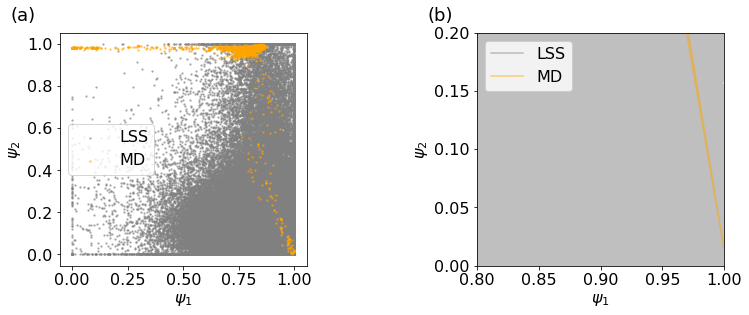

In [183]:
concat_synth_trajs = synth_trajs.reshape(synth_trajs.shape[0] * synth_trajs.shape[1], 3)
subplot_labels = ['(a)', '(b)']
fig, axes = plt.subplots(1, 2)
ax = axes[0]
ax.scatter(concat_synth_trajs[:, 0], concat_synth_trajs[:, 1], s=2, label='LSS', alpha=0.5, c='grey')
ax.scatter(traj_prop_scaled[:, 0], traj_prop_scaled[:, 1], s=2, label='MD', alpha=0.5, c='orange')
ax = axes[1]
ax.plot(synth_trajs[0, :, 0], synth_trajs[0, :, 1], label='LSS', alpha=0.5, c='grey')
ax.plot(traj_prop_scaled[::100, 0], traj_prop_scaled[::100, 1], label='MD', alpha=0.5, c='orange')
ax.set_xlim([0.8, 1.0])
ax.set_ylim([0, 0.2])
for item in range(2):
    axes[item].set_xlabel('$\psi_1$')
    axes[item].set_ylabel('$\psi_2$')
    axes[item].legend()
    add_label_to_subplot(axes[item], subplot_labels[item])
fig.tight_layout()
fig.set_size_inches(12, 5)
fig.savefig('R1.png', bbox_inches='tight')

/Users/aawad.19/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/aawad.19/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/aawad.19/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: array must not contain infs or NaNs

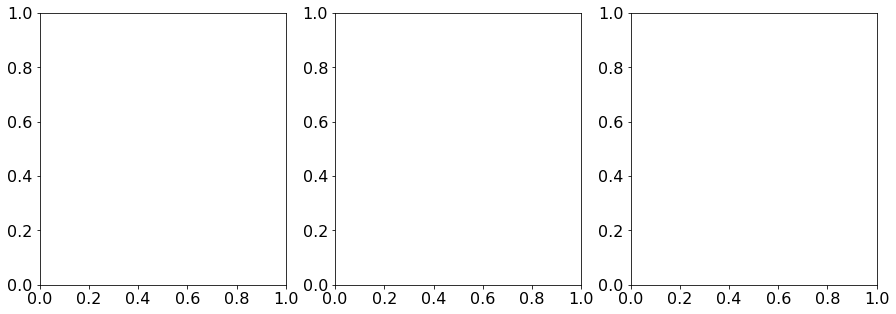

In [184]:
data_for_autocorr = [traj_prop_scaled, synth_trajs]
unit_convert_factor = [5000, 50]
lag_time_max = [6, 1, 1]
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
color_list = ['orange', 'grey']
label_list = ['MD', 'LSS']

from scipy.optimize import curve_fit
def exp_func(lag, temp_t):
    return np.exp(- lag / temp_t)

for item in range(3):
    ax = axes[item]
    for _1 in range(2):
        lag_list = np.array(range(1, lag_time_max[item] * unit_convert_factor[_1], 
                                  lag_time_max[item] * unit_convert_factor[_1] // 10))
        if _1 == 0:
            temp_autocorr = [get_autocorr(traj_prop_scaled[:, item], item_lag) for item_lag in lag_list]
            popt, pcov = curve_fit(exp_func, lag_list / unit_convert_factor[_1], temp_autocorr)
#             print("MD (i = %d): k, t_i, c_i = " % (item + 1), popt)
#             print("MD (i = %d): t_i = " % (item + 1), popt)

            len_block = traj_prop_scaled.shape[0] // 5
            temp_autocorr_block = [[get_autocorr(
                traj_prop_scaled[item_traj * len_block: (item_traj + 1) * len_block, item], item_lag) 
                        for item_lag in lag_list] for item_traj in range(5)]
            
        else:
            temp_autocorr = [get_autocorr(synth_trajs[:, :, item], item_lag) for item_lag in lag_list]
            popt, pcov = curve_fit(exp_func, lag_list / unit_convert_factor[_1], temp_autocorr)
#             print("LSS (i = %d): k, t_i, c_i = " % (item + 1), popt)
#             print("LSS (i = %d): t_i = " % (item + 1), popt)
            len_block = synth_trajs.shape[0] // 5
            temp_autocorr_block = [[get_autocorr(
                synth_trajs[item_traj * len_block: (item_traj + 1) * len_block, :, item], item_lag) 
                        for item_lag in lag_list] for item_traj in range(5)]
        ax.plot(lag_list / unit_convert_factor[_1], temp_autocorr, c=color_list[_1], label=label_list[_1])
        for item_traj in range(5):
            ax.plot(lag_list / unit_convert_factor[_1], temp_autocorr_block[item_traj], '--', alpha=0.3,
                    c=color_list[_1])
        ax.set_xlabel('$\\tau$/$\mu$s')
        ax.set_ylabel('$C_%d(\\tau)$' % (item + 1))
    ax.legend()
fig.tight_layout()
fig.savefig('R2.pdf', bbox_inches='tight')

In [233]:
#x_prop = prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), 10000)
#x_prop = x_prop.reshape(10000, -1)

In [234]:
-lag / np.log(np.corrcoef(traj_prop[:-lag:lag, 0], traj_prop[lag::lag, 0])[0][1])*0.2

434.6498184886298

In [235]:
def get_timescales_blocking(trajs, lag_time, num_blocks):
    result = []
    temp_size = trajs.shape[0] // num_blocks
    for item in range(num_blocks):
        temp_traj = trajs[item * temp_size: (item+1) * temp_size]
        if temp_traj.ndim == 1:
            temp_pair = (temp_traj[:-lag_time:lag_time], temp_traj[lag_time::lag_time])
        elif temp_traj.ndim == 2:
            temp_pair = (np.concatenate([item_traj[:-lag_time:lag_time] for item_traj in temp_traj]),
                         np.concatenate([item_traj[lag_time::lag_time] for item_traj in temp_traj]))
        result.append(-lag_time / np.log(np.corrcoef(temp_pair[0], temp_pair[1])[0,1]))
    return np.array(result)

for item in range(3):
    timescales_md = get_timescales_blocking(traj_prop_scaled[:, item], 100, 5)
    print(0.2 * timescales_md.mean(), 0.2 * timescales_md.std())
for item in range(3):
    timescales_lss = get_timescales_blocking(synth_trajs[:,:, item], 1, 5)
    print(100 * 0.2 * timescales_lss.mean(), 100 * 0.2 * timescales_lss.std())

nan nan
nan nan
nan nan
11.158098961308184 0.03247696882157672
nan nan
nan nan


/Users/aawad.19/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [236]:
np.array(synth_timescales).mean(axis=0), np.array(synth_timescales).std(axis=0)

(array([55.75034738,         nan,         nan]),
 array([2.62648283,        nan,        nan]))

In [237]:
synth_timescales = []
for st in synth_trajs:
    
    tss = []
    for i in range(st.shape[1]):
        tc = np.corrcoef(st[:-1:1,i], st[1::1,i])[0,1]
        ts = -lag/np.log(tc)
        tss.append(ts)
    synth_timescales.append(tss)

/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


In [238]:
synth_timescales = np.array(synth_timescales)

In [239]:
ref_timescales = [] 
for i in range(3):
    tc = np.corrcoef(traj_prop_scaled[:-lag:lag,i], traj_prop_scaled[lag::lag,i])[0,1]
    ts = -lag/np.log(tc)
    ref_timescales.append(ts)

ref_timescales = np.array(ref_timescales)

/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [240]:
sort_idx = np.argsort(np.sqrt(np.sum((synth_timescales - ref_timescales)**2, axis=1)))

In [241]:
top_synth_trajs = [synth_trajs[i] for i in sort_idx[:10]]  # choose optimal 10 synthetic trajectories
#print(top_synth_trajs)

In [242]:
np.mean(synth_timescales[sort_idx[:10]], axis=0)

array([56.94323545,         nan,         nan])

In [243]:
np.std(synth_timescales[sort_idx[:10]], axis=0)

array([2.27541677,        nan,        nan])

In [244]:
ref_timescales

array([2173.24907372,   96.03837423,           nan])

In [245]:
counts_transitions = np.array([14, 9, 11, 11, 12, 10, 11, 10, 8, 11])
print(counts_transitions.mean(), counts_transitions.std())

10.7 1.5524174696260022


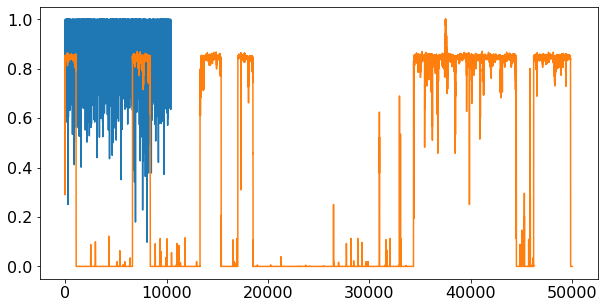

In [246]:
fig, ax = plt.subplots()
ax.plot(top_synth_trajs[9][:, 0])
ax.plot(traj_prop_scaled[:, 0])
fig.set_size_inches((10, 5))

## Free energy comparison

In [201]:
best_traj = top_synth_trajs[0]

In [202]:
Ff_s, xf_s = np.histogram(np.concatenate(top_synth_trajs)[:,0], bins=100)
Ff_r, xf_r = np.histogram(traj_prop_scaled[:,0], bins=100)

In [203]:
x_ticks = np.arange(0, 1.01, 0.01)

In [204]:
def uncertainty_with_blocking(data_to_use, num=5):
    fes_list = []
    data_length = data_to_use.shape[0]
    for _1 in range(num):
        itersample = data_to_use[data_length // num * _1: data_length // num * (_1+1)]
        fes_count = np.histogram(itersample, bins=x_ticks, density=False)[0] + 1
        fes_count = fes_count / fes_count.sum()
        fes_list.append(-np.log(fes_count))
    fes_list = np.array(fes_list)
    confidence_interval = np.array([fes_list.mean(axis=0) - 1.96 * fes_list.std(axis=0),
                           fes_list.mean(axis=0) + 1.96 * fes_list.std(axis=0)]).T
    return fes_list, confidence_interval

fes_list_md, confidence_interval_md = uncertaity_with_blocking(traj_prop_scaled[:,0])
fes_list_lss, confidence_interval_lss = uncertaity_with_blocking(np.concatenate(synth_trajs)[:, 0], num=5)

In [205]:
# bootstrap for uncertainty estimation
def bootstrap_for_uncertainty_estimate(data_to_use, num=100):
    fes_list = []
    for _ in range(num):
        itersample = np.random.choice(data_to_use, size=data_to_use.shape, replace=True)
        fes_list.append(-np.log(np.histogram(itersample, bins=x_ticks, density=True)[0]))
    fes_list = np.array(fes_list)
    high_per, low_per = 1 - 0.025, 0.025
    confidence_interval = []
    for item in fes_list.T:
        item.sort()
        nn = len(item)
        low_val, high_val = item[int(np.floor(nn * low_per))], item[int(np.floor(nn * high_per))]
        confidence_interval.append([low_val, high_val])
    confidence_interval = np.array(confidence_interval)
    return fes_list, confidence_interval

# fes_list_md, confidence_interval_md = bootstrap_for_uncertainty_estimate(traj_prop_scaled[:,0])
# fes_list_lss, confidence_interval_lss = bootstrap_for_uncertainty_estimate(np.concatenate(synth_trajs)[:, 0])

In [206]:
np.mean((confidence_interval_md[:, 1] - confidence_interval_md[:, 0]) 
        / (confidence_interval_lss[:, 1] - confidence_interval_lss[:, 0]))

39.54928331523131

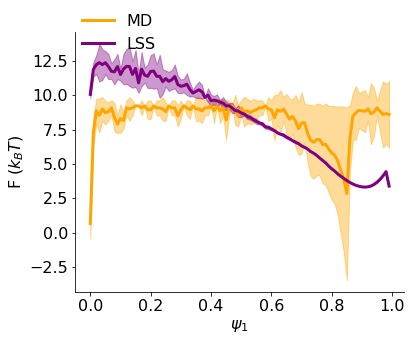

In [247]:
fes_offset = fes_list_md.mean() - fes_list_lss.mean()
fes_list_lss = fes_list_lss + fes_offset
confidence_interval_lss = confidence_interval_lss + fes_offset
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(6, 5))
plt.plot(x_ticks[:-1], np.mean(fes_list_md, axis=0), linewidth=3, color='orange')
plt.plot(x_ticks[:-1], np.mean(fes_list_lss, axis=0), linewidth=3, color='purple')
plt.fill_between(x_ticks[:-1], confidence_interval_md[:, 0], confidence_interval_md[:, 1], alpha=0.4, color='orange')
plt.fill_between(x_ticks[:-1], confidence_interval_lss[:, 0], confidence_interval_lss[:, 1], alpha=0.4, color='purple')
plt.xlabel(r'$\psi_1$')
plt.ylabel('F ($k_BT$)')
i = 0
for spine in plt.gca().spines.values():
    if (i+1) % 2 == 0:
        spine.set_visible(False)
    i += 1
    
plt.legend(['MD', 'LSS'], frameon=False, loc=(0, 0.9))

plt.tight_layout()    
plt.savefig('fes_comparison.png', dpi=300)

In [227]:
# np.sqrt(np.mean((-np.log(Ff_r) - (-np.log(Ff_s)-1.2))**2))

In [228]:
def gen_mol_traj(x_scaled):
    molgen.is_fitted = True
    x_unscaled = prop_scaler.inverse_transform(x_scaled)
    synth = scaler.inverse_transform(molgen.transform(x_unscaled)).reshape(-1, 20, 3)
    gen_traj = traj_ca.slice(range(synth.shape[0]))
    
    for i in range(len(gen_traj)):
        gen_traj.xyz[i] = synth[i] 

    gen_traj.superpose(gen_traj[0])
    
    return gen_traj

In [229]:
def get_closest_frames(val, idx, traj, n=10):
    matches = np.argsort(np.abs(traj[:,idx] - val))
    return matches[:n]

In [230]:
def get_RMSD_within_SRV_range(traj, srv_val, val_lo, val_hi):
    idx = (srv_val > val_lo) & (srv_val < val_hi)
    frames = traj[idx]
    result = np.sqrt(frames.xyz.var(axis=0).sum(axis=1).mean())
    return result

print(get_RMSD_within_SRV_range(traj_ca, traj_prop_scaled[:, 0], 0.4, 0.5))
print(get_RMSD_within_SRV_range(md.join(synth_all_trajs),
                                np.concatenate(synth_trajs)[:, 0], 0.4, 0.5))

0.17716458


NameError: name 'synth_all_trajs' is not defined

Select structures closest to different CV values, then generate ensembles.

First pose

In [212]:
synth_idx = get_closest_frames(0., 0, best_traj)
ref_idx = get_closest_frames(0, 0, traj_prop_scaled)

In [213]:
synth_mol_1 = gen_mol_traj(best_traj[synth_idx])
ref_mol_1 = traj_ca[ref_idx]

ValueError: could not broadcast input array from shape (20,3) into shape (10,3)

In [214]:
np.mean(np.concatenate([md.rmsd(synth_mol_1, ref_mol_1[i]) for i in range(len(ref_mol_1))]))*10 # Angstrom

NameError: name 'ref_mol_1' is not defined

In [215]:
np.mean(md.rmsd(synth_mol_1, ref_mol_1[6]))*10 # Angstrom. Central structure. 

NameError: name 'synth_mol_1' is not defined

In [216]:
ref_2jof = md.load('/Users/aawad/OneDrive/Documents/LSS_all_files/2jof.pdb')
ref_2jof = ref_2jof.atom_slice(ref_2jof.top.select_atom_indices('alpha'))
np.mean(md.rmsd(synth_mol_1, ref_2jof))

OSError: No such file: /Users/aawad/OneDrive/Documents/LSS_all_files/2jof.pdb

In [217]:
synth_mol_1.save_pdb('synth_mol_1.pdb')
ref_mol_1.save_pdb('ref_mol_1.pdb')

NameError: name 'synth_mol_1' is not defined

Third pose

In [ ]:
synth_idx = get_closest_frames(0.45, 0, best_traj)
ref_idx = get_closest_frames(0.45, 0, traj_prop_scaled)

In [ ]:
synth_mol_3 = gen_mol_traj(best_traj[synth_idx])
ref_mol_3 = traj_ca[ref_idx]

In [ ]:
synth_mol_3.save_pdb('synth_mol_3.pdb')
ref_mol_3.save_pdb('ref_mol_3.pdb')

In [218]:
np.mean(np.concatenate([md.rmsd(synth_mol_3, ref_mol_3[i]) for i in range(len(ref_mol_3))]))*10 # Angstrom

NameError: name 'ref_mol_3' is not defined

## TICA

In [219]:
import pyemma as py

In [220]:
featurizer = py.coordinates.featurizer(traj_ca.topology)
featurizer.add_distances_ca(periodic=False)

In [221]:
feature_source = py.coordinates.source(traj_ca.xyz, features=featurizer)

In [222]:
feature_data = feature_source.get_output()[0]

In [223]:
tica = py.coordinates.tica(data=feature_data, lag=100, dim=3, kinetic_map=True)

In [224]:
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

In [231]:
synth_all_trajs = [gen_mol_traj(x) for x in synth_trajs]

ValueError: could not broadcast input array from shape (20,3) into shape (10,3)

In [ ]:
synth_full = [x.xyz for x in synth_all_trajs]

In [ ]:
py.config.show_progress_bars = False

In [ ]:
synth_feat_source = py.coordinates.source(synth_full, features=featurizer)

In [ ]:
synth_feature_data = synth_feat_source.get_output()

In [ ]:
synth_tica_list = tica.transform(synth_feature_data)
synth_tica_output = np.concatenate(synth_tica_list)

In [ ]:
np.array([get_timescales([item[:, _1] for item in synth_tica_list], 1) * 100 for _1 in range(3)]) * 0.2

In [ ]:
tica.timescales[:5] * 0.2

In [ ]:
tica_timescales_blocks_md = np.array([get_timescales_blocking(tica_concatenated[:, ii], lag, 5) for ii in range(3)])
tica_timescales_blocks_lss = np.array([get_timescales_blocking(np.array(synth_tica_list)[:,:,ii], 1, 5) for ii in range(3)])
print(tica_timescales_blocks_md.mean(axis=1) * 0.2, tica_timescales_blocks_md.std(axis=1) * 0.2, 
      tica_timescales_blocks_lss.mean(axis=1) * 20, tica_timescales_blocks_lss.std(axis=1) * 20)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 7), sharex=True)

y_axes = [(-2.7, 2.7), (-3, 2)]
for i in range(2):
    _, _, misc = py.plots.plot_free_energy(tica_concatenated[::10,0], tica_concatenated[::10,i+1], ax=ax[i,0], cbar_label=None, legacy=False)
    misc['cbar'].set_ticks(np.arange(0, 11))
    _, _, misc = py.plots.plot_free_energy(synth_tica_output[::10,0], synth_tica_output[::10,i+1], ax=ax[i,1], legacy=False)    
    misc['cbar'].set_ticks(np.arange(0, 11))
    ax[i,0].set_ylim(y_axes[i])
    ax[i,1].set_ylim(y_axes[i])
    ax[i,1].set_yticks([])
    ax[i,0].set_xlim([-2.5, 2])
    ax[i,1].set_xlim([-2.5, 2])

ax[0,0].set_title('MD')
ax[0,1].set_title('LSS')
ax[0,0].set_ylabel('TIC2')
ax[1,0].set_xlabel('TIC1')
ax[1,0].set_ylabel('TIC3')
ax[1,1].set_xlabel('TIC1')
plt.tight_layout()
plt.savefig('tica_trpcage.pdf', dpi=300)

In [ ]:
# for i, x_dim in enumerate(x_prop.T):
#     plt.hist(2*(x_dim-0.5), bins=100);
#     plt.hist(traj_prop[::100, i], bins=100, alpha=0.5);
#     plt.show()

## Compare timescales

In [267]:
for i in range(3):
    tc = np.corrcoef(traj_prop_scaled[:-lag:lag,i], traj_prop_scaled[lag::lag,i])[0,1]
    ts = -lag/np.log(tc)
    print(f'Reference Timescale {i}: {ts}')
    
    tc = np.corrcoef(x_prop[:-1:1,i], x_prop[1::1,i])[0,1]
    ts = -lag/np.log(tc)

    print(f'Synthetic Timescale {i}: {ts}\n')

Reference Timescale 0: 2173.2490737164603
Synthetic Timescale 0: 61.17026538614878

Reference Timescale 1: 96.03837422683024
Synthetic Timescale 1: nan

Reference Timescale 2: nan
Synthetic Timescale 2: nan



/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [268]:
srv.timescales_

array([2063.09231095,  520.24998669,  150.20381646])

In [269]:
x_prop_unscaled = prop_scaler.inverse_transform(x_prop)

## Sample molecules

In [252]:
molgen.is_fitted = True

In [253]:
synth = scaler.inverse_transform(molgen.transform(x_prop_unscaled)).reshape(-1, 20, 3)

Using synthetic data, override existing mdtraj struct

In [254]:
gen_traj = traj_ca.slice(range(synth.shape[0]))

In [255]:
for i in range(len(gen_traj)):
    gen_traj.xyz[i] = synth[i] 

ValueError: could not broadcast input array from shape (20,3) into shape (10,3)

In [256]:
gen_traj.superpose(gen_traj[0])

<mdtraj.Trajectory with 5000 frames, 10 atoms, 10 residues, and unitcells at 0x1a9233b290>

In [257]:
nv.show_mdtraj(gen_traj)

NGLWidget(max_frame=4999)

Save trajectory

In [265]:
gen_traj.save_pdb('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/synthetic_trajectory_chig.pdb')

In [277]:
nv.show_file('/Users/aawad.19/Documents/Ferguson Lab/LSS_all_files/Chignolin/synthetic_trajectory_chig.pdb')

NGLWidget()

In [263]:
generated_complete_traj = gen_mol_traj(best_traj)

ValueError: could not broadcast input array from shape (20,3) into shape (10,3)

In [264]:
nv.show_mdtraj(generated_complete_traj)

NameError: name 'generated_complete_traj' is not defined

## more analysis

In [ ]:
real_rg = md.compute_rg(traj_ca)
synth_rg = np.concatenate([md.compute_rg(item) for item in synth_all_trajs])

In [ ]:
# _ = plt.hist(real_rg, normed=True, cumulative=True, label='CDF',
#          histtype='step', alpha=0.8, color='k', bins=20)
# _ = plt.hist(synth_rg, normed=True, cumulative=True, label='CDF',
#          histtype='step', alpha=0.8, color='k', bins=20)

In [ ]:
print(real_rg.mean(), real_rg.std(), synth_rg.mean(), synth_rg.std())

In [ ]:
from scipy.stats import ks_2samp
ks_2samp(real_rg, synth_rg)

In [ ]:
fig, ax = plt.subplots()
hist_bins = np.linspace(0.5, 1.8, 15)
_ = ax.hist(real_rg, alpha=0.5, bins=hist_bins, normed=True, label='original')
_ = ax.hist((synth_rg), alpha=0.5, bins=hist_bins, normed=True, label='synthetic')
ax.legend()
ax.set_xlabel('$R_g$/nm')
ax.set_ylabel('probability density')
fig.savefig('rg_hist.pdf', bbox_inches = 'tight', dpi=300)

In [ ]:
data_to_plot = real_rg
plt.plot(data_to_plot)
plt.hlines(0.7, 0, data_to_plot.shape[0], color='r')
plt.hlines(1.5, 0, data_to_plot.shape[0], color='y')

In [ ]:
# compute mean first passage time
def get_state(rg):
    result_states = rg
    result_states[np.where(rg < 0.7)] = 0
    result_states[np.all([0.7 <= real_rg, real_rg < 1.5], axis=0)] = 1
    result_states[np.where(rg >= 1.5)] = 2
    return result_states
    
real_states = get_state(real_rg)

In [ ]:
def get_mfpt_list(states_list, current_state):
    mfpt = []
    events = []
    current_idx = 0
    for idx, item in enumerate(states_list):
        if abs(item - current_state) == 2:
            mfpt.append(idx - current_idx)
            events.append([current_idx, idx])
            current_state = item
            current_idx = idx
    return np.array(mfpt), np.array(events)

real_mfpt, events = get_mfpt_list(real_states, 0)

In [ ]:
############################

In [ ]:
_, dihedrals = md.compute_psi(traj)

In [ ]:
plt.plot(np.sin(dihedrals[:, 17]))